# Stock Prices Prediction Using Keras Long Term Short Memory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


#PART 1 - DATA PREPROCESSING

Seed = '2020'
os.environ['PYTHONHASHSEED'] = Seed
np.random.seed(int(Seed))
rn.seed(Seed)
tf.random.set_seed(int(Seed))

dataset_train = pd.read_csv('TSLA.csv')
dataset_train = dataset_train.loc[:871, :]
training_set = dataset_train.iloc[:, 1:2].values



sc = MinMaxScaler(feature_range = (0, 1)) 

training_set_scaled = sc.fit_transform(training_set)


In [2]:

#PART 2 - BUILDING THE MODEL

X_train = []
y_train = []
for i in range(25, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-25:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train[2])
X_train.shape

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and Dropout regularisation
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1)) 

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 150, batch_size = 48, validation_split=0.15, shuffle = False)

Epoch 1/150
15/15 [==============================] - 7s 222ms/step - loss: 0.0091 - val_loss: 0.1223
Epoch 2/150
15/15 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0620
Epoch 3/150
15/15 [==============================] - 0s 27ms/step - loss: 8.5884e-04 - val_loss: 0.0704
Epoch 4/150
15/15 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0396
Epoch 5/150
15/15 [==============================] - 0s 27ms/step - loss: 7.0874e-04 - val_loss: 0.0277
Epoch 6/150
15/15 [==============================] - 0s 27ms/step - loss: 6.8811e-04 - val_loss: 0.0193
Epoch 7/150
15/15 [==============================] - 0s 27ms/step - loss: 6.9246e-04 - val_loss: 0.0189
Epoch 8/150
15/15 [==============================] - 0s 27ms/step - loss: 6.9665e-04 - val_loss: 0.0234
Epoch 9/150
15/15 [==============================] - 0s 27ms/step - loss: 7.5579e-04 - val_loss: 0.0259
Epoch 10/150
15/15 [==============================] - 0s 27ms/step - loss: 

15/15 [==============================] - 0s 27ms/step - loss: 2.6012e-04 - val_loss: 0.0069
Epoch 80/150
15/15 [==============================] - 0s 27ms/step - loss: 2.5639e-04 - val_loss: 0.0068
Epoch 81/150
15/15 [==============================] - 0s 27ms/step - loss: 2.5102e-04 - val_loss: 0.0058
Epoch 82/150
15/15 [==============================] - 0s 27ms/step - loss: 2.1265e-04 - val_loss: 0.0056
Epoch 83/150
15/15 [==============================] - 0s 27ms/step - loss: 2.3984e-04 - val_loss: 0.0067
Epoch 84/150
15/15 [==============================] - 0s 27ms/step - loss: 2.4864e-04 - val_loss: 0.0069
Epoch 85/150
15/15 [==============================] - 0s 28ms/step - loss: 2.5340e-04 - val_loss: 0.0061
Epoch 86/150
15/15 [==============================] - 0s 27ms/step - loss: 2.3521e-04 - val_loss: 0.0057
Epoch 87/150
15/15 [==============================] - 0s 32ms/step - loss: 2.2743e-04 - val_loss: 0.0059
Epoch 88/150
15/15 [==============================] - 0s 28ms/step -

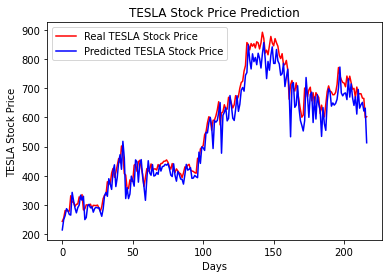

In [3]:
# PART 3 - MAKING THE PREDICTIONS AND VISUALIZING THE RESULTS

# Getting the real stock price of 2020
dataset_test = pd.read_csv('tatatest.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values


# Getting the predicted stock price of 2020
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 25:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []

for i in range(25, len(inputs)):
    X_test.append(inputs[i-25:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plt.plot(real_stock_price, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [4]:
#PART 4 - GETTING MEAN PERCENTAGE OF ERROR

def getInfo():

    dataFrame = pd.DataFrame(columns = ['real', 'predicted', 'absDiff', 'PercDiff'])

    dataFrame['real'] = [i for j in real_stock_price for i in j]
    dataFrame['predicted'] = [i for j in predicted_stock_price for i in j]
    dataFrame['absDiff'] = abs(dataFrame['real'] - dataFrame['predicted'])
    dataFrame['PercDiff'] = dataFrame['absDiff']*100/dataFrame['real']

    print("Mean percentage of error +-" + str(dataFrame['PercDiff'].mean())+"%")


getInfo()

Mean percentage of error +-6.109077039618594%


(200.0, 700.0)

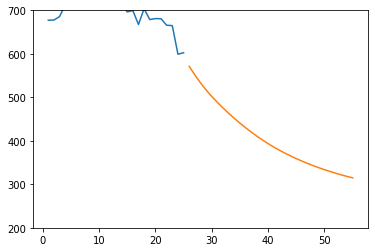

In [5]:
#PART 5 - PREDICTING FUTURE VALUE


dataset_test = pd.read_csv('tatatest.csv')
scaler=MinMaxScaler(feature_range=(0,1))
dataset_test = dataset_test.iloc[:, 1:2]
dataset_test=scaler.fit_transform(dataset_test).reshape(-1,1)

x_input = dataset_test[len(dataset_test)-25:].reshape(1,-1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

output=[]
n_steps=25
i=0
while(i<30):

    if(len(temp_input)>25):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = regressor.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = regressor.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1

print(" ")
day_new=np.arange(1,26)
day_pred=np.arange(26,56)



plt.plot(day_new,scaler.inverse_transform(dataset_test[192:]))
plt.plot(day_pred,scaler.inverse_transform(output))

plt.ylim([200,700])


